In [84]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from matplotlib import patches

from scipy.stats import shapiro, rankdata, friedmanchisquare, ttest_rel, wilcoxon
from statsmodels.stats.anova import AnovaRM
from scikit_posthocs import posthoc_ttest, posthoc_wilcoxon, posthoc_tukey_hsd, posthoc_tukey
import pingouin as pg

import numpy as np
import scipy
import config as c

In [85]:
clicks_df = pd.DataFrame()
latency_conditions = [-40, -20, 0, 20, 40]
balanced_latin_square = [[0,1,4,3,2],
                        [4,2,0,3,1],
                        [3,2,1,4,0],
                        [1,0,3,4,2],
                        [4,0,2,1,3],
                        [2,3,4,1,0],
                        [1,3,0,2,4],
                        [0,4,1,2,3],
                        [2,4,3,0,1],
                        [3,1,2,0,4]]
for id in range(c.NUM_PARTICIPANTS):
    for trial in range(c.NUM_TRIALS):
        clicks_raw = pd.read_csv(
            c.FOLDER_PATH
            + str(id + 1)
            + f"/clicks_participant_{id + 1}_trial_{trial}.csv"
        )
        clicks_raw["level_of_latency"] = latency_conditions[balanced_latin_square[id][trial]]
        clicks_df = pd.concat([clicks_df, clicks_raw])
    
clicks_df.head()

,id,timestamp_ms,participant_id,trial,level_of_latency,target_number,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,0,1710166191603,1,0,-40,0,30,450,959,103,957,107,1,1.787344
1,1,1710166193111,1,0,-40,1,30,450,1113,975,1117,968,1,1.508388
2,2,1710166194311,1,0,-40,2,30,450,670,208,672,211,1,1.199971
3,3,1710166196228,1,0,-40,3,30,450,1349,778,1353,787,1,1.916836
4,4,1710166197495,1,0,-40,4,30,450,516,474,519,467,1,1.267135


In [86]:
# drop irrelevant columns
clicks_df = clicks_df.drop(
    ["timestamp_ms", "target_number"], axis=1
)
# drop rows of first click in round (no fitts law task)
clicks_df = clicks_df.drop(clicks_df.loc[clicks_df["id"] % 9 == 0].index, axis=0)
clicks_df.reset_index(inplace=True, drop=True)
clicks_df.head()

,id,participant_id,trial,level_of_latency,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,1,1,0,-40,30,450,1113,975,1117,968,1,1.508388
1,2,1,0,-40,30,450,670,208,672,211,1,1.199971
2,3,1,0,-40,30,450,1349,778,1353,787,1,1.916836
3,4,1,0,-40,30,450,516,474,519,467,1,1.267135
4,5,1,0,-40,30,450,1403,474,1409,482,1,1.045496


In [87]:
# calculation of id
clicks_df["ID"] = np.log2(clicks_df["target_amplitude"] / clicks_df["target_width"] + 1)

In [88]:
# drop rows with unsuccessful fitts law tasks
error_indices = clicks_df.loc[clicks_df["success"]==0].index
task_after_error_indices = clicks_df.loc[clicks_df["success"]==0].index + 1
clicks_error_df = clicks_df.drop(error_indices, axis=0)
clicks_error_df = clicks_df.drop(task_after_error_indices, axis=0)

clicks_error_df.reset_index(inplace=True, drop=True)
clicks_error_df

,id,participant_id,trial,level_of_latency,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time,ID
0,1,1,0,-40,30,450,1113,975,1117,968,1,1.508388,4.0
1,2,1,0,-40,30,450,670,208,672,211,1,1.199971,4.0
2,3,1,0,-40,30,450,1349,778,1353,787,1,1.916836,4.0
3,4,1,0,-40,30,450,516,474,519,467,1,1.267135,4.0
4,5,1,0,-40,30,450,1403,474,1409,482,1,1.045496,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13687,319,10,4,40,200,200,763,518,733,513,1,0.400253,1.0
13688,320,10,4,40,200,200,1156,518,1150,500,1,0.387485,1.0
13689,321,10,4,40,200,200,786,652,775,637,1,0.408640,1.0
13690,322,10,4,40,200,200,1088,399,1106,392,1,0.353753,1.0


In [89]:
# calculation of effective id
num_ids = len(clicks_df["ID"].unique())

clicks_df["distance_from_target"] = np.sqrt(
    (clicks_df["target_x"] - clicks_df["cursor_x"])**2 +
    (clicks_df["target_y"] - clicks_df["cursor_y"])**2
)

effective_id_df = pd.DataFrame({"ID": clicks_df["ID"].unique(), 
                                "sigma": np.zeros(num_ids),
                                "amplitude": np.zeros(num_ids),
                                "width": np.zeros(num_ids)})
for _, entry in clicks_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            row["amplitude"] = entry["target_amplitude"]
            row["width"] = entry["target_width"]
            row["sigma"] += entry["distance_from_target"]

effective_id_df["sigma"] /= len(clicks_df)/9
effective_id_df["We"] = 4.133 * effective_id_df["sigma"]
effective_id_df["IDe"] = np.log2(
    effective_id_df["amplitude"] / effective_id_df["We"] + 1
)
effective_id_df.sort_values(by=["ID"])

,ID,sigma,amplitude,width,We,IDe
5,1.000000,31.052660,200.0,200.0,128.340645,1.355215
3,1.392317,43.412532,325.0,200.0,179.423994,1.491264
8,1.415037,25.310623,200.0,120.0,104.608803,1.541953
6,1.700440,45.337543,450.0,200.0,187.380066,1.766186
2,1.890771,28.969335,325.0,120.0,119.730262,1.893143
7,2.247928,27.515706,450.0,120.0,113.722411,2.309468
4,2.938599,8.739127,200.0,30.0,36.118814,2.708691
1,3.564785,8.955104,325.0,30.0,37.011443,3.289992
0,4.000000,9.303153,450.0,30.0,38.449931,3.667158


In [90]:
# calculation of throughput
throughput_df = pd.DataFrame({"IDe": np.zeros(clicks_error_df.shape[0]),
                              "completion_time": clicks_error_df["completion_time"]})

for index, entry in clicks_error_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            throughput_df.loc[index,"IDe"] = round(row["IDe"], 2)

throughput_df["throughput"] = throughput_df["IDe"] / throughput_df["completion_time"]
throughput_df["level_of_latency"] = clicks_error_df["level_of_latency"]
throughput_df["participant_id"] = clicks_error_df["participant_id"]
throughput_df

,IDe,completion_time,throughput,level_of_latency,participant_id
0,3.67,1.508388,2.433061,-40,1
1,3.67,1.199971,3.058407,-40,1
2,3.67,1.916836,1.914613,-40,1
3,3.67,1.267135,2.896298,-40,1
4,3.67,1.045496,3.510296,-40,1
...,...,...,...,...,...
13687,1.36,0.400253,3.397851,40,10
13688,1.36,0.387485,3.509813,40,10
13689,1.36,0.408640,3.328113,40,10
13690,1.36,0.353753,3.844490,40,10


In [91]:
# calculation of throughput
error_df = pd.DataFrame({"IDe": np.zeros(clicks_df.shape[0]),
                              "error_rate": 1 - clicks_df["success"]})

for index, entry in clicks_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            error_df.loc[index,"IDe"] = round(row["IDe"], 2)

error_df["level_of_latency"] = clicks_df["level_of_latency"]
error_df["participant_id"] = clicks_df["participant_id"]
error_df

,IDe,error_rate,level_of_latency,participant_id
0,3.67,0,-40,1
1,3.67,0,-40,1
2,3.67,0,-40,1
3,3.67,0,-40,1
4,3.67,0,-40,1
...,...,...,...,...
14395,1.36,0,40,10
14396,1.36,0,40,10
14397,1.36,0,40,10
14398,1.36,0,40,10


In [92]:
grouped_error_df = error_df.groupby(["level_of_latency", "participant_id"], as_index=False).mean()
grouped_error_df

,level_of_latency,participant_id,IDe,error_rate
0,-40,1,2.225556,0.038194
1,-40,2,2.225556,0.027778
2,-40,3,2.225556,0.156250
3,-40,4,2.225556,0.173611
4,-40,5,2.225556,0.006944
5,-40,6,2.225556,0.059028
6,-40,7,2.225556,0.013889
7,-40,8,2.225556,0.031250
8,-40,9,2.225556,0.013889
9,-40,10,2.225556,0.072917


# Inferential Analysis
- one-way repeated-measures ANOVA (+correction??) for latency throughput
- one-way repeated-measures ANOVA for latency -> movement time
- one-way repeated-measures ANOVA for latency -> error rate
- one-way repeated-measures ANOVA for latency -> nasa tlx

### ANOVA: latency -> throughput 

In [93]:
# test for normal distribution
pg.sphericity(data=throughput_df, dv='throughput', within='level_of_latency', subject="participant_id")

SpherResults(spher=False, W=0.055364034522145646, chi2=21.46253610196117, dof=9, pval=0.012579682657181027)

In [94]:
pg.normality(data=throughput_df, dv='throughput', group='level_of_latency')


,W,pval,normal
level_of_latency,,,
-40,0.981692,3.289499e-18,False
-20,0.996282,2.500765e-06,False
40,0.930898,7.816663e-34,False
20,0.946207,1.313446e-30,False
0,0.940731,8.872024e-32,False


In [95]:
aov = pg.rm_anova(data=throughput_df, dv='throughput', within='level_of_latency', subject="participant_id", correction=True)
# Sphericity assumption not met -> use mauchly test chisquare with greenhouse geisser corrected p-value of the anova

aov

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,level_of_latency,4,36,1.802052,0.149838,0.195808,0.040118,0.474553,False,0.055364,0.01258


In [96]:
pg.pairwise_tests(data=throughput_df, dv='throughput', within='level_of_latency', subject="participant_id", return_desc=True, padjust='holm')

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,level_of_latency,-40,-20,3.380510,0.600081,3.606218,0.532915,True,True,-1.891355,9.0,two-sided,0.091139,0.726859,holm,1.129,-0.380923
1,level_of_latency,-40,0,3.380510,0.600081,3.756441,0.914746,True,True,-1.966758,9.0,two-sided,0.080762,0.726859,holm,1.233,-0.465428
2,level_of_latency,-40,20,3.380510,0.600081,3.743648,0.616986,True,True,-2.219759,9.0,two-sided,0.053585,0.535851,holm,1.673,-0.571473
3,level_of_latency,-40,40,3.380510,0.600081,3.611136,0.756151,True,True,-1.960162,9.0,two-sided,0.081623,0.726859,holm,1.223,-0.323592
4,level_of_latency,-20,0,3.606218,0.532915,3.756441,0.914746,True,True,-0.624439,9.0,two-sided,0.547840,1.000000,holm,0.364,-0.192197
5,level_of_latency,-20,20,3.606218,0.532915,3.743648,0.616986,True,True,-0.825112,9.0,two-sided,0.430634,1.000000,holm,0.41,-0.228320
6,level_of_latency,-20,40,3.606218,0.532915,3.611136,0.756151,True,True,-0.026761,9.0,two-sided,0.979234,1.000000,holm,0.309,-0.007200
7,level_of_latency,0,20,3.756441,0.914746,3.743648,0.616986,True,True,0.109864,9.0,two-sided,0.914928,1.000000,holm,0.31,0.015705
8,level_of_latency,0,40,3.756441,0.914746,3.611136,0.756151,True,True,1.319232,9.0,two-sided,0.219667,1.000000,holm,0.613,0.165831
9,level_of_latency,20,40,3.743648,0.616986,3.611136,0.756151,True,True,1.001863,9.0,two-sided,0.342584,1.000000,holm,0.466,0.183910


### ANOVA: latency -> error rate

In [97]:
pg.normality(data=error_df, dv='error_rate', group='level_of_latency')


,W,pval,normal
level_of_latency,,,
-40,0.249883,1.597507e-75,False
-20,0.206237,1.081057e-76,False
40,0.222867,2.970278e-76,False
20,0.203010,8.903887e-77,False
0,0.222867,2.970278e-76,False


In [98]:
pg.sphericity(grouped_error_df, dv="error_rate", within="level_of_latency", subject="participant_id")

c:\Users\sinas\MasterWorkspace\WS_23\Forschungsseminar\SpeedyMouseEvaluation\.venv\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


SpherResults(spher=True, W=inf, chi2=-inf, dof=9, pval=1.0)

In [99]:
aov = pg.rm_anova(data=grouped_error_df, dv='error_rate', within="level_of_latency", subject="participant_id", correction=True)
# Sphericity assumption not met -> use mauchly test chisquare with greenhouse geisser corrected p-value of the anova

aov

c:\Users\sinas\MasterWorkspace\WS_23\Forschungsseminar\SpeedyMouseEvaluation\.venv\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,level_of_latency,4,36,1.274408,0.29806,0.304278,0.01664,0.60964,True,inf,1.0


In [100]:
pg.pairwise_tests(data=error_df, dv='error_rate', within=['level_of_latency'], subject="participant_id", return_desc=True, padjust='holm').to_csv('anova.csv')

### ANOVA: latency -> completion time

In [101]:
pg.normality(data=throughput_df, dv='completion_time', group='level_of_latency')

,W,pval,normal
level_of_latency,,,
-40,0.919627,9.440820e-36,False
-20,0.920528,7.583550e-36,False
40,0.926512,1.128059e-34,False
20,0.920923,8.793687e-36,False
0,0.933705,2.875276e-33,False


In [104]:
throughput_df

,IDe,completion_time,throughput,level_of_latency,participant_id
0,3.67,1.508388,2.433061,-40,1
1,3.67,1.199971,3.058407,-40,1
2,3.67,1.916836,1.914613,-40,1
3,3.67,1.267135,2.896298,-40,1
4,3.67,1.045496,3.510296,-40,1
...,...,...,...,...,...
13687,1.36,0.400253,3.397851,40,10
13688,1.36,0.387485,3.509813,40,10
13689,1.36,0.408640,3.328113,40,10
13690,1.36,0.353753,3.844490,40,10


In [103]:
throughput_df[throughput_df['level_of_latency'] == '-40']

,IDe,completion_time,throughput,level_of_latency,participant_id


Test for normal distribution for dependent variable completion_time:
-40ms: ShapiroResult(statistic=0.9196270751988218, pvalue=9.440820299338158e-36)
-20ms: ShapiroResult(statistic=0.9205278243693897, pvalue=7.58354959874487e-36)
0ms: ShapiroResult(statistic=0.9337048270679951, pvalue=2.875276045268132e-33)
20ms: ShapiroResult(statistic=0.920923129532507, pvalue=8.793687244627159e-36)
40ms: ShapiroResult(statistic=0.9265117993320704, pvalue=1.1280585515731612e-34)


<Axes: xlabel='completion_time', ylabel='Density'>

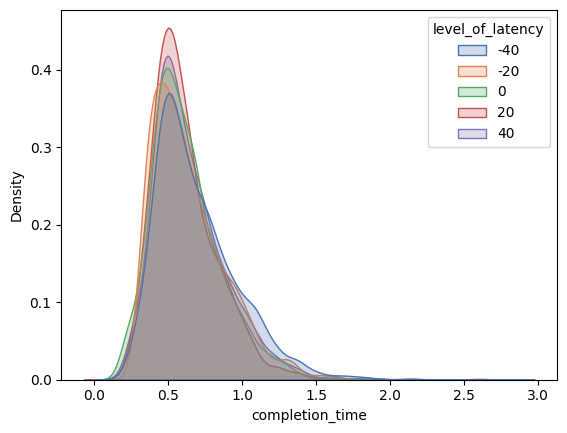

In [105]:
dv = 'completion_time'

normal_neg40   = shapiro(throughput_df[throughput_df['level_of_latency'] == -40][dv])
normal_neg20  = shapiro(throughput_df[throughput_df['level_of_latency'] == -20][dv])
normal_0  = shapiro(throughput_df[throughput_df['level_of_latency'] == 0][dv])
normal_20  = shapiro(throughput_df[throughput_df['level_of_latency'] == 20][dv])
normal_40  = shapiro(throughput_df[throughput_df['level_of_latency'] == 40][dv])

print(f'Test for normal distribution for dependent variable {dv}:')
print(f'-40ms: {normal_neg40}')
print(f'-20ms: {normal_neg20}')
print(f'0ms: {normal_0}')
print(f'20ms: {normal_20}')
print(f'40ms: {normal_40}')

sns.kdeplot(data=throughput_df, x=dv, hue='level_of_latency', fill=True, palette='deep')

In [ ]:
anova = AnovaRM(data=throughput_df, depvar='completion_time', subject='participant_id', within=['level_of_latency'], aggregate_func='mean').fit()
anova.anova_table

,F Value,Num DF,Den DF,Pr > F
level_of_latency,2.732835,4.0,36.0,0.043903


In [ ]:
aov = pg.rm_anova(data=throughput_df, dv='completion_time', within=['level_of_latency'], subject="participant_id", correction=True)
# Sphericity assumption not met -> use mauchly test chisquare with greenhouse geisser corrected p-value of the anova

aov

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,level_of_latency,4,36,2.732835,0.043903,0.076086,0.054803,0.626211,True,430.847982,1.0


In [109]:
pg.pairwise_tests(data=throughput_df, dv='completion_time', within=['level_of_latency'], subject="participant_id", return_desc=True, padjust='holm')#.to_csv('anova_completion_time.csv')

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,level_of_latency,-40,-20,0.683785,0.116536,0.633018,0.103368,True,True,2.452544,9.0,two-sided,0.036604,0.292829,holm,2.236,0.441420
1,level_of_latency,-40,0,0.683785,0.116536,0.619040,0.124677,True,True,2.528041,9.0,two-sided,0.032339,0.291052,holm,2.459,0.513855
2,level_of_latency,-40,20,0.683785,0.116536,0.607486,0.086443,True,True,2.762445,9.0,two-sided,0.022024,0.220239,holm,3.316,0.712243
3,level_of_latency,-40,40,0.683785,0.116536,0.638615,0.133628,True,True,1.977299,9.0,two-sided,0.079404,0.555828,holm,1.248,0.345063
4,level_of_latency,-20,0,0.633018,0.103368,0.619040,0.124677,True,True,0.454704,9.0,two-sided,0.660091,1.000000,holm,0.337,0.116903
5,level_of_latency,-20,20,0.633018,0.103368,0.607486,0.086443,True,True,1.059362,9.0,two-sided,0.317037,1.000000,holm,0.487,0.256642
6,level_of_latency,-20,40,0.633018,0.103368,0.638615,0.133628,True,True,-0.181246,9.0,two-sided,0.860191,1.000000,holm,0.313,-0.044870
7,level_of_latency,0,20,0.619040,0.124677,0.607486,0.086443,True,True,0.638131,9.0,two-sided,0.539284,1.000000,holm,0.367,0.103151
8,level_of_latency,0,40,0.619040,0.124677,0.638615,0.133628,True,True,-1.190228,9.0,two-sided,0.264404,1.000000,holm,0.545,-0.145073
9,level_of_latency,20,40,0.607486,0.086443,0.638615,0.133628,True,True,-1.120257,9.0,two-sided,0.291607,1.000000,holm,0.513,-0.264924


## Inferential analysis of NASA-TLX

In [ ]:
tlx_df = pd.DataFrame()
for id in range(c.NUM_PARTICIPANTS):
    tlx_raw = pd.read_csv(
        c.FOLDER_PATH
        + str(id + 1)
        + f"/tlx_participant_{id + 1}.csv"
    )
    tlx_raw["level_of_latency"] = balanced_latin_square[id]
    tlx_df = pd.concat([tlx_df, tlx_raw])

tlx_df.drop(["latency", "trial"], axis=1, inplace=True)

tlx_df.head()

,participant_id,mental_demand,physical_demand,temporal_demand,performance,effort,frustration,level_of_latency
0,1,8.0,10.0,16.2,2.0,13.0,4.8,0
1,1,14.0,10.8,14.2,8.4,12.2,11.2,1
2,1,16.4,15.8,8.6,12.2,14.0,8.6,4
3,1,10.8,13.0,4.6,6.6,11.0,4.0,3
4,1,8.2,8.2,12.2,6.2,7.0,4.4,2


In [ ]:
scores = []
for row, entry in tlx_df.drop(["participant_id", "level_of_latency"], axis=1).iterrows():
    scores.append(np.mean(entry))

tlx_df["score"] = scores
tlx_df.head() 

,participant_id,mental_demand,physical_demand,temporal_demand,performance,effort,frustration,level_of_latency,score
0,1,8.0,10.0,16.2,2.0,13.0,4.8,0,9.000000
1,1,14.0,10.8,14.2,8.4,12.2,11.2,1,11.800000
2,1,16.4,15.8,8.6,12.2,14.0,8.6,4,12.600000
3,1,10.8,13.0,4.6,6.6,11.0,4.0,3,8.333333
4,1,8.2,8.2,12.2,6.2,7.0,4.4,2,7.700000


In [ ]:
tlx_df.groupby(["level_of_latency"], as_index=False).mean()

,level_of_latency,participant_id,mental_demand,physical_demand,temporal_demand,performance,effort,frustration,score
0,0,5.5,8.84,6.66,7.10,6.64,8.70,7.48,7.570000
1,1,5.5,9.28,6.50,7.00,7.40,8.54,7.94,7.776667
2,2,5.5,6.48,4.98,6.46,5.96,6.88,6.46,6.203333
3,3,5.5,7.14,5.22,6.66,5.84,7.34,6.72,6.486667
4,4,5.5,6.56,5.36,5.80,7.34,7.02,6.54,6.436667


In [ ]:
aov = pg.rm_anova(data=tlx_df, dv='score', within='level_of_latency', subject="participant_id", correction=True)

aov

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,level_of_latency,4,36,2.20619,0.087808,0.125376,0.046373,0.612165,True,0.253261,0.347414


In [ ]:
# test for normal distribution
pg.normality(data=tlx_df, dv='mental_demand', group='level_of_latency')

,W,pval,normal
level_of_latency,,,
0,0.891258,0.175192,True
1,0.946255,0.624453,True
4,0.847449,0.054164,True
3,0.913088,0.302882,True
2,0.951594,0.687387,True


In [ ]:
aov = pg.rm_anova(data=tlx_df, dv='mental_demand', within='level_of_latency', subject="participant_id", correction=True)

aov

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,level_of_latency,4,36,2.572453,0.054173,0.102147,0.051399,0.51415,False,0.062663,0.017151


In [ ]:
pg.normality(data=tlx_df, dv='temporal_demand', group='level_of_latency')

,W,pval,normal
level_of_latency,,,
0,0.852864,0.062826,True
1,0.925658,0.406567,True
4,0.903189,0.237401,True
3,0.889009,0.165268,True
2,0.896022,0.198024,True


In [ ]:
aov = pg.rm_anova(data=tlx_df, dv='temporal_demand', within='level_of_latency', subject="participant_id", correction=True)

aov

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,level_of_latency,4,36,0.290692,0.88209,0.772659,0.006193,0.554902,False,0.034666,0.003746


In [ ]:
aov = pg.rm_anova(data=tlx_df, dv='physical_demand', within='level_of_latency', subject="participant_id", correction=True)

aov

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,level_of_latency,4,36,1.493966,0.224499,0.249284,0.022863,0.540986,True,0.21664,0.264135


In [ ]:
aov = pg.rm_anova(data=tlx_df, dv='performance', within='level_of_latency', subject="participant_id", correction=True)

aov

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,level_of_latency,4,36,0.783136,0.543636,0.517997,0.028673,0.781422,True,0.474895,0.792552


In [ ]:
aov = pg.rm_anova(data=tlx_df, dv='effort', within='level_of_latency', subject="participant_id", correction=True)

aov

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,level_of_latency,4,36,1.60005,0.195444,0.217264,0.034174,0.681431,True,0.271587,0.389808


In [ ]:
aov = pg.rm_anova(data=tlx_df, dv='frustration', within='level_of_latency', subject="participant_id", correction=True)

aov

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,level_of_latency,4,36,0.726628,0.579601,0.549433,0.018603,0.778444,True,0.529803,0.862889
